In [1]:
!pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import constants
from scipy import signal
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import dblquad
from matplotlib.ticker import MultipleLocator
import pylab
import astropy.units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM, z_at_value
from scipy.special import gamma as gamma_func
from matplotlib.colors import LogNorm

In [3]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.waveform
from pycbc.types import TimeSeries
from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd import interpolate, inverse_spectrum_truncation
import pylab
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.noise
import pycbc.psd
from pycbc.filter import matched_filter
from pycbc.filter import sigma
from mpmath import mp
from astropy.cosmology import Planck18 as cosmo
from matplotlib.ticker import LogLocator, LogFormatter
from pycbc.psd import welch

/home/rosar/phd/personal/phd/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/home/rosar/phd/personal/phd/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrai

In [4]:
from functools import partial
import multiprocessing
from tqdm import tqdm
from multiprocessing import cpu_count

ncpu = cpu_count()
print(f"{ncpu} CPUs")

20 CPUs


$\Omega$ parameter

In [5]:
def omega (Ml,f):
    solar_mass_kg = 1.9891e30*u.kilogram
    Ml_kg = Ml*solar_mass_kg
    f_Hz = f*u.hertz

    cons = 8*np.pi*G*(c**(-3))
    omega = cons * Ml_kg * f_Hz
    return omega.value


In [6]:
f_range = np.linspace(0.001,500,100)
m_range = np.logspace (-2,8,100)

m_grid,f_grid = np.meshgrid(f_range,m_range,indexing = 'ij')
omega_grid = omega(m_grid,f_grid)
omega_grid.reshape(m_grid.shape)

array([[1.23834054e-09, 1.56260854e-09, 1.97178834e-09, ...,
        7.77713952e+00, 9.81363703e+00, 1.23834054e+01],
       [6.25547100e-06, 7.89350914e-06, 9.96047884e-06, ...,
        3.92861810e+04, 4.95735379e+04, 6.25547100e+04],
       [1.25097037e-05, 1.57854557e-05, 1.99189859e-05, ...,
        7.85645848e+04, 9.91372621e+04, 1.25097037e+05],
       ...,
       [6.06661806e-04, 7.65520376e-04, 9.65977156e-04, ...,
        3.81001295e+06, 4.80769107e+06, 6.06661806e+06],
       [6.12916039e-04, 7.73412323e-04, 9.75935663e-04, ...,
        3.84929135e+06, 4.85725479e+06, 6.12916039e+06],
       [6.19170272e-04, 7.81304269e-04, 9.85894170e-04, ...,
        3.88856976e+06, 4.90681851e+06, 6.19170272e+06]], shape=(100, 100))

<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_6478/3974718379.py:5: SyntaxWarning: invalid escape sequence '\O'
  plt.clabel(contour_line,inline=True,fmt='$\Omega$=1')
/tmp/ipykernel_6478/3974718379.py:7: SyntaxWarning: invalid escape sequence '\O'
  plt.clabel(contour_line2,inline=True,fmt='$\Omega = 10⁴$')
/tmp/ipykernel_6478/3974718379.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Lens mass ($M_\odot$)')
/tmp/ipykernel_6478/3974718379.py:4: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour_line = plt.contour(m_grid,f_grid,omega_grid,levels =[1],colors = 'red',linewidth = 2)
/tmp/ipykernel_6478/3974718379.py:6: UserWarning: The following kwargs were not used by contou

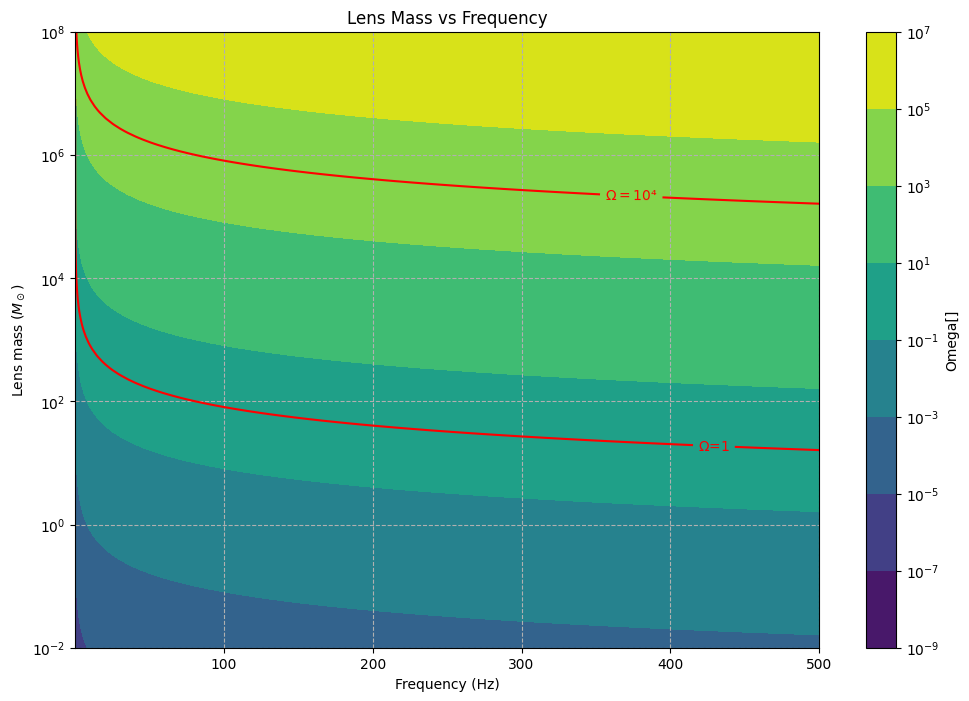

In [19]:
plt.figure(figsize=(12,8))
contour = plt.contourf(m_grid,f_grid,omega_grid,levels = 30,norm = LogNorm())
plt.colorbar(contour,label = 'Omega[]')
contour_line = plt.contour(m_grid,f_grid,omega_grid,levels =[1],colors = 'red',linewidth = 2)
plt.clabel(contour_line,inline=True,fmt='$\Omega$=1')
contour_line2 = plt.contour(m_grid,f_grid,omega_grid,levels =[10000],colors = 'red',linewidth = 2)
plt.clabel(contour_line2,inline=True,fmt='$\Omega = 10⁴$')
plt.yscale('log')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Lens mass ($M_\odot$)')
pylab.grid(True, which="both", ls="--")
plt.title('Lens Mass vs Frequency')
gw_bands = {
    'LISA': (0.001, 0.1),
    'LIGO/Virgo': (10, 500),
    'ET': (1, 500)
}


lens_types = {
    'Planetary': (0.01, 0.1),
    'Stellar': (1, 100),
    'SMBH': (1e4, 1e8)
}



In [ ]:
def geometric_optics_model(dl_pc, ds_pc, M_sm, beta_arcsec):

    solar_mass_kg = 1.9891e30*u.kilogram
    dl_m = (dl_pc*u.pc).to(u.m)
    ds_m = (ds_pc*u.pc).to(u.m)
    M_kg = M_sm * solar_mass_kg
    beta_rad = (beta_arcsec*u.arcsec).to(u.m)
    d_ls_m = ds_m - dl_m
    z_l = z_at_value(cosmo.angular_diameter_distance,dl_pc*u.pc, zmax=10)
    if d_ls_m <= 0:
        return 0, 0, 0

    einstein_rad_sq = (4 * G.value * M_kg / c.value**2) * (d_ls_m / (ds_m * dl_m))
    einstein_rad = np.sqrt(einstein_rad_sq)
    w = beta_rad / einstein_rad


    sqrt_term = np.sqrt(w**2 + 4)
    mag_plus = 0.5 * (1 + (w**2 + 2) / (w * sqrt_term))
    mag_minus = 0.5 * (1 - (w**2 + 2) / (w * sqrt_term))

    time_delay_const = (1 + z_l) * (4 * G.value * M_kg / c.value**3)
    term1 = (w * sqrt_term) / 2
    term2 = np.log((sqrt_term + w) / (sqrt_term - w))

    time_delay_difference = time_delay_const * (term1 + term2) #faster computation of time delay between both images- this is the same mathematics

    return mag_plus, mag_minus, time_delay_difference

In [22]:
def einstein_radius_calc(M_sm, ds_pc, dl_pc):
    if ds_pc <= dl_pc: 
        return 0
    
    solar_mass_kg = 1.9891e30*u.kilogram
    dl_m = (dl_pc*u.pc).to(u.m)
    ds_m = (ds_pc*u.pc).to(u.m)
    M_kg = M_sm * solar_mass_kg
    d_ls_m = ds_m - dl_m
    
    einstein_rad_sq = (4 * G.value * M_kg / (c.value**2)) * (d_ls_m / (ds_m * dl_m))
    return np.sqrt(einstein_rad_sq)

In [24]:
def beta_einst_rad_ratio (M_sm,dl_pc,beta_arcsec):
    ds_pc = 1e9
    beta_rad = (beta_arcsec*u.arcsec).to(u.m)

    einst_rad_rad = einstein_radius_calc(M_sm,ds_pc,dl_pc)

    beta_norm_to_einst_radius = beta_rad/einst_rad_rad

    return beta_norm_to_einst_radius
    

In [40]:
def blind_time_delay_eikonal(M_sm, beta_to_erad_ratio,dl_pc):

    solar_mass_kg = 1.9891e30*u.kilogram
    M_kg = M_sm * solar_mass_kg
    if dl_pc <=100:
        z_l = 0
    else: 
        z_l = z_at_value(cosmo.angular_diameter_distance,dl_pc*u.pc, zmax=10)
    w = beta_to_erad_ratio


    sqrt_term = np.sqrt(w**2 + 4)
    #Magnification of both images
    mag_plus = 0.5 * (1 + (w**2 + 2) / (w * sqrt_term))
    mag_minus = 0.5 * (1 - (w**2 + 2) / (w * sqrt_term))

    #Time-delay between both images
    time_delay_const = (1 + z_l) * (4 * G * M_kg / c**3)
    term1 = (w * sqrt_term) / 2
    term2 = np.log((sqrt_term + w) / (sqrt_term - w))
    time_delay_difference = time_delay_const * (term1 + term2) #faster computation of time delay between both images- this is the same mathematics

    return mag_plus, mag_minus, time_delay_difference

In [150]:

beta_to_erad_ratio = np.array([0.01,0.1,0.3,0.5,0.7,1,1.2,1.5,2,3,5,10])
dl_pc = 5*1e4 #LMC

M_range = np.logspace(-2,10,12)
f_range = np.linspace(0.001,500,12) #LISA+ET+LVK

f_grid,M_grid = np.meshgrid(f_range,M_range, indexing = 'ij')
#Which frequency-M_l set gives eikonal regime ? 
omega_grid = omega(M_grid,f_grid) 
mask = omega_grid>=1
eik_omega = omega_grid[mask]
eik_omega = eik_omega.reshape(2)
eik_f = f_grid[mask]
eik_M = M_grid[mask]

mp,mm,td = blind_time_delay_eikonal(M_sm = 10,beta_to_erad_ratio=10000000,dl_pc=20)
ratio = len(eik_omega)/len(omega_grid.flatten())*100
print (f'{ratio:.1f}% of couples induces eikonal regime')

ValueError: cannot reshape array of size 93 into shape (2,)

<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_6478/1463177306.py:8: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Lens mass ($M_\odot$)')
/tmp/ipykernel_6478/1463177306.py:8: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Lens mass ($M_\odot$)')


TypeError: Input z must be 2D, not 1D

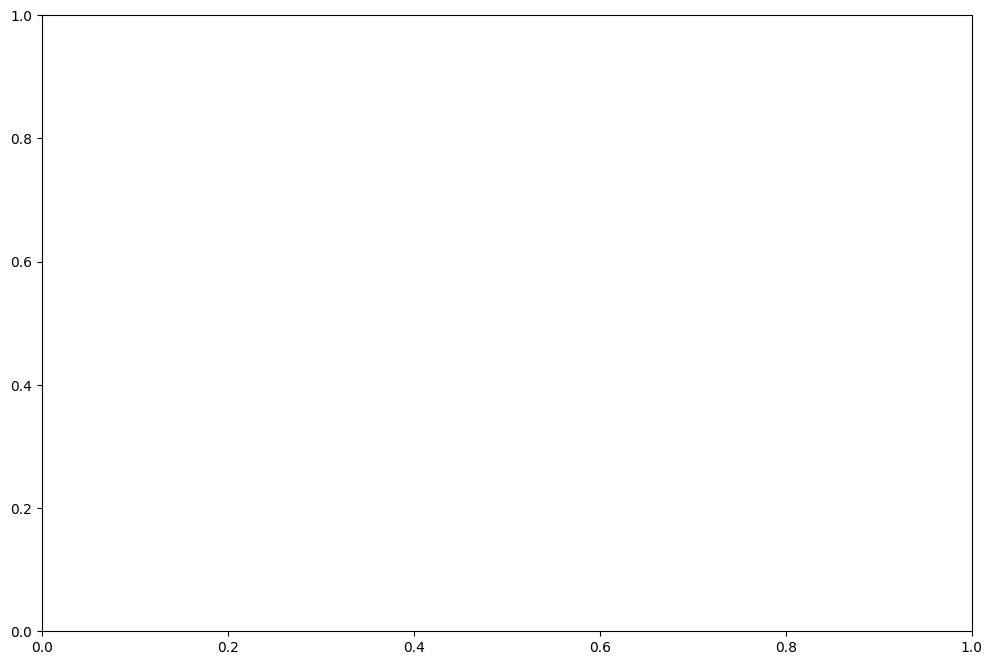

In [148]:
plt.figure(figsize=(12,8))
contour = plt.contourf(eik_f,eik_M,eik_omega,levels = 30,norm = LogNorm())
plt.colorbar(contour,label = 'Omega_eikonal[]')

plt.yscale('log')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Lens mass ($M_\odot$)')
pylab.grid(True, which="both", ls="--")
plt.title('Lens Mass vs Frequency')

In [104]:
azb

array([8.14745387e+00, 1.00445619e+02, 1.23834054e+03, 1.30035658e+00,
       1.60314037e+01, 1.97642638e+02, 2.43663082e+03, 3.00399236e+04,
       3.70346219e+05, 4.56580129e+06, 5.62893323e+07, 2.60068456e+00,
       3.20624548e+01, 3.95280928e+02, 4.87320804e+03, 6.00791864e+04,
       7.40684291e+05, 9.13150213e+06, 1.12577426e+08, 3.90101253e+00,
       4.80935058e+01, 5.92919219e+02, 7.30978525e+03, 9.01184492e+04,
       1.11102236e+06, 1.36972030e+07, 1.68865520e+08, 5.20134051e+00,
       6.41245569e+01, 7.90557509e+02, 9.74636247e+03, 1.20157712e+05,
       1.48136043e+06, 1.82629038e+07, 2.25153614e+08, 6.50166849e+00,
       8.01556079e+01, 9.88195799e+02, 1.21829397e+04, 1.50196975e+05,
       1.85169851e+06, 2.28286046e+07, 2.81441708e+08, 7.80199646e+00,
       9.61866590e+01, 1.18583409e+03, 1.46195169e+04, 1.80236237e+05,
       2.22203658e+06, 2.73943055e+07, 3.37729802e+08, 9.10232444e+00,
       1.12217710e+02, 1.38347238e+03, 1.70560941e+04, 2.10275500e+05,
      

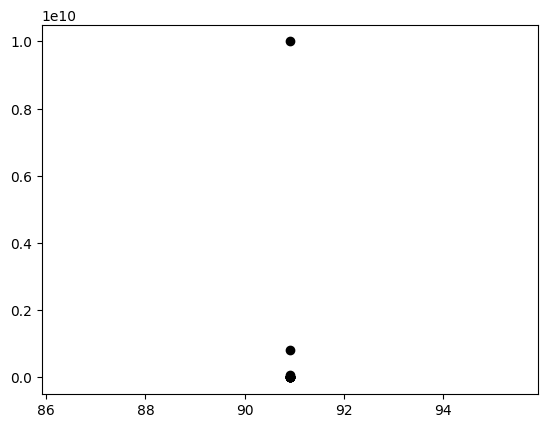

In [92]:
plt.plot(f_grid[2], M_grid[3], marker='o', color='k', linestyle='none')
plt.show()

In [79]:
omega_grid[1][1]

np.float64(0.0006939611976120003)

In [48]:
mm

np.float64(0.0)

In [5]:
from gwosc import datasets
from gwosc.datasets import run_segment


In [68]:
catalogs = datasets.find_datasets(type='run')
print (catalogs)

['O1', 'O2', 'O3GK', 'O3a', 'O3b', 'O4a', 'O4b3Disc', 'S5', 'S6']


In [6]:
events = datasets.find_datasets(type='events')

In [90]:
print(events)

['151008-v1', '151012.2-v1', '151116-v1', '161202-v1', '161217-v1', '170208-v1', '170219-v1', '170405-v1', '170412-v1', '170423-v1', '170616-v1', '170630-v1', '170705-v1', '170720-v1', '190924_232654-v1', '191118_212859-v1', '191223_014159-v1', '191225_215715-v1', '200114_020818-v1', '200121_031748-v1', '200201_203549-v1', '200214_224526-v1', '200214_224526-v2', '200219_201407-v1', '200311_103121-v1', 'GRB051103-v1', 'GW150914-v1', 'GW150914-v2', 'GW150914-v3', 'GW151012-v1', 'GW151012-v2', 'GW151012-v3', 'GW151226-v1', 'GW151226-v2', 'GW170104-v1', 'GW170104-v2', 'GW170608-v1', 'GW170608-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v1', 'GW170814-v2', 'GW170814-v3', 'GW170817-v1', 'GW170817-v2', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1', 'GW190403_051519-v1', 'GW190408_181802-v1', 'GW190408_181802-v2', 'GW190408_181802-v3', 'GW190412-v1', 'GW190412-v2', 'GW190412-v3', 'GW190412-v5', 'GW190412_053044-v4', 'GW190413_052954-v1', 'GW190413_052954-v2', 'GW190413_052954-v3'

In [91]:
print (len(events))

356


In [7]:
detected_gw = []
for e in events:
    if (len(e) <=11) & (e[0] == 'G'):
        detected_gw.append(e)

In [96]:
print(len(detected_gw))

36


In [102]:
print(detected_gw[0])

GW150914-v1


In [8]:
from gwpy.timeseries import TimeSeries as gwpy_ts
data = gwpy_ts.fetch_open_data('H1',
                                  datasets.event_gps(detected_gw[0]),
                                  datasets.event_gps(detected_gw[0])+16
)

In [ ]:
data.

<TimeSeries([-2.64076922e-19, -2.95929189e-19, -2.94362862e-19,
             ..., -6.44526154e-21, -6.36026905e-21,
             -3.74912730e-20]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625946e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>